# Electron Photon tagging

This is a first test to implement a QAE. 
The task is to identify Electrons and Photons from em-calorimeter images.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import tensorflow as tf
import tensorflow_quantum as tfq
from hep_VQAE import data_preprocessing as dp
from hep_VQAE import CAE as cae
from tensorflow.keras import layers, losses

import warnings
warnings.filterwarnings('ignore')

2022-07-06 11:32:48.687933: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-06 11:32:48.688011: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-07-06 11:32:50.775025: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-06 11:32:50.775088: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-06 11:32:50.775124: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tomskopfbahnhof): /proc/driver/nvidia/version does not exist
2022-07-06 11:32:50.775541: I tensorflow/core/platform/cpu_fe

In [2]:
import h5py

In [3]:
f = h5py.File("../../data/electron.hdf5","r")
f2 = h5py.File("../../data/photon.hdf5","r")

In [4]:
f.get('X')[:].shape

(249000, 32, 32, 2)

In [5]:
electrons = f.get('X')[:,:,:,0]
photons = f2.get('X')[:,:,:,0]
electrons_y = f.get('y')[:]
photons_y = f2.get('y')[:]

In [6]:
from sklearn.model_selection import train_test_split



x_train, x_val, y_train, y_val = train_test_split(np.vstack((electrons,photons)),
                                                    np.transpose(np.hstack((electrons_y, photons_y))),
                                                    test_size=0.2, shuffle=True)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train,
                                                    test_size=0.4, shuffle=True)

In [7]:
x_train_electrons = x_train[y_train==1]
x_train = x_train[y_train==0]

x_val_electrons = x_val[y_val==1]
x_val = x_val[y_val==0]

x_test_electrons = x_test[y_test==1]
x_test = x_test[y_test==0]

In [8]:
x_train = x_train.reshape(x_train.shape + (1,))
x_train_electrons = x_train_electrons.reshape(x_train_electrons.shape + (1,))

x_val = x_val.reshape(x_val.shape + (1,))
x_val_electrons = x_val_electrons.reshape(x_val_electrons.shape + (1,))

x_test = x_test.reshape(x_test.shape + (1,))
x_test_electrons = x_test_electrons.reshape(x_test_electrons.shape + (1,))

In [9]:
latent_dim = 2
ae = cae.VAE()

In [10]:
ae.compile(optimizer=tf.keras.optimizers.Adam())

In [11]:
es = tf.keras.callbacks.EarlyStopping(monitor='reconstruction_loss', patience=3)
hist = ae.fit(x_train,
                epochs=12,
                shuffle=True,
                #validation_data=x_test,
                callbacks=[es])

Epoch 1/12
3744/3744 [==============================] - 131s 34ms/step - loss: 23.3319 - reconstruction_loss: 6.3363 - kl_loss: 0.1538
Epoch 2/12
3744/3744 [==============================] - 135s 36ms/step - loss: 3.2011 - reconstruction_loss: 3.1997 - kl_loss: 2.0622e-06
Epoch 3/12
3744/3744 [==============================] - 126s 34ms/step - loss: 3.1985 - reconstruction_loss: 3.1998 - kl_loss: 1.1887e-06
Epoch 4/12
3744/3744 [==============================] - 135s 36ms/step - loss: 3.1979 - reconstruction_loss: 3.1997 - kl_loss: 1.2462e-06
Epoch 5/12
3744/3744 [==============================] - 125s 33ms/step - loss: 3.2026 - reconstruction_loss: 3.1986 - kl_loss: 1.1749e-06
Epoch 6/12
3744/3744 [==============================] - 123s 33ms/step - loss: 3.1998 - reconstruction_loss: 3.1982 - kl_loss: 1.3827e-06
Epoch 7/12
3744/3744 [==============================] - 136s 36ms/step - loss: 3.1979 - reconstruction_loss: 3.1975 - kl_loss: 1.2331e-06
Epoch 8/12
3744/3744 [===============

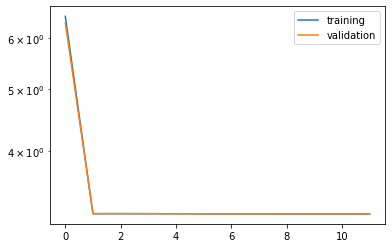

In [12]:
plt.plot(hist.history['loss'], label="training")
plt.plot(hist.history['reconstruction_loss'], label="validation")
plt.yscale('log')
plt.legend()

In [13]:
def mae(x):
    pred = ae.predict(x)
    return np.mean(np.abs(x - pred)**2,axis=(1,2,3))

def recon_acc(x):
    return 1 - mae(x)

def IF(x):
    pred = ae.predict(x)
    return 1 - np.sum((x - pred)**2,axis=(1,2))/np.sum(x*pred,axis=(1,2))
def IF2(x):
    pred = ae.predict(x)
    return 1 - np.sum((x - pred)**2,axis=(1,2))/np.sum(x**2,axis=(1,2))

(79731, 32, 32, 1)

In [17]:
photons = recon_acc(x_test)
electrons = recon_acc(x_test_electrons)



In [20]:
photon_energy = np.sum(x_test,axis=(1,2,3))
electron_energy = np.sum(x_test_electrons,axis=(1,2,3))

0.99992007
0.9999205


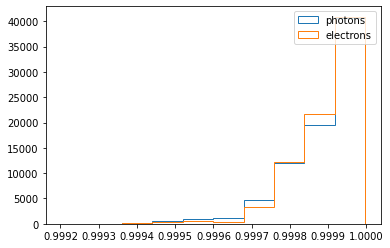

In [15]:
print(np.median(photons))
bins = np.histogram(np.hstack((photons, electrons)), bins=10)[1]
plt.hist(photons, histtype='step', label="photons",bins=bins)#,bins=[0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013])
print(np.median(electrons))
plt.hist(electrons, histtype='step', label="electrons",bins=bins)#,bins=[0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013])
plt.legend()

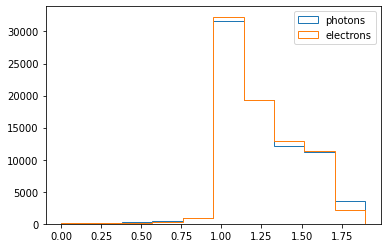

In [21]:
bins = np.histogram(np.hstack((photon_energy, electron_energy)), bins=10)[1]
plt.hist(photon_energy, histtype='step', label="photons",bins=bins)#,bins=[0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013])
plt.hist(electron_energy, histtype='step', label="electrons",bins=bins)#,bins=[0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013])
plt.legend()

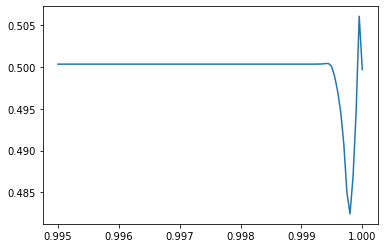

In [16]:
def acc_for_threshold(T):
    # sixes that are predicted photon
    num_six_right = np.sum(photons > T)
    # threes that are predicted three
    num_three_right = np.sum(electrons < T)
   
    acc = (num_six_right + num_three_right)/(len(photons) + len(electrons))
    return acc

Ts = np.linspace(0.995,1,100)
accs = []
for i in Ts:
    accs.append(acc_for_threshold(i))
plt.plot(Ts, accs) 